### Sample program for LSTM (N-d input/output)  
https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html  

#### Import libraries  

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [48]:
np.random.seed(11)
tf.random.set_seed(11)

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [49]:
df = pd.read_csv('weather_in_tokyo_and_icecream_in_japan-utf8.csv', 
                 skiprows=6, delimiter=',', header=0)
df['Month'] = pd.to_datetime(df['Month'])
df.head()


,Month,x1,x2,x3,x4,y1
0,2003-01-01,9.3,101.0,46,0,331
1,2003-02-01,9.9,53.5,52,0,268
2,2003-03-01,12.7,159.5,49,0,365
3,2003-04-01,19.2,121.0,61,3,492
4,2003-05-01,22.4,172.5,65,7,632


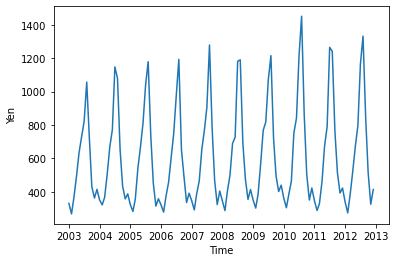

In [50]:
plt.plot(df['Month'], df['y1'])
plt.xlabel("Time")
plt.ylabel("Yen")
plt.show()

In [71]:
w = 24 #24 months for training, making prediction for the next 12months
n_out = 12
n_test = 12

In [72]:
print(xy.shape)


sc = MinMaxScaler(feature_range=(0, 1), copy=True)
xy = df.drop(columns='Month')
sc.fit(xy[:-n_test]) #grabbing all elements excluding the last 12 for testing
xy_std = sc.transform(xy)
print(xy_std.shape)

(120, 5)
(120, 5)


In [73]:
#training data
weather = xy_std[:,:-1] #xy_std is a np arr, while xy is a pd dataframe
weather.shape

(120, 4)

In [74]:
#label
icecream = xy_std[:,-1]
icecream.shape

(120,)

In [75]:
#praring sliding window
x = []
y = []
n_months = icecream.shape[0]
for i in range(0, n_months - w - n_out):
    x.append(weather[i:i+w]) #always grab an amount of w
    y.append(icecream[i + w : i + w + n_out]) #same as above, but grab n_out AFTER x
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(84, 24, 4)
(84, 12)


In [79]:
#building model
n_hidden = 20

es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode = 'auto')
model = Sequential()

#(24, 4) input shape
model.add(LSTM(n_hidden, input_shape = (x.shape[1], x.shape[2]), return_sequences = False))

model.add(Dense(n_out, activation='linear'))
model.summary()
model.compile(loss='mean_squared_error',optimizer='adam')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20)                2000      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                252       
Total params: 2,252
Trainable params: 2,252
Non-trainable params: 0
_________________________________________________________________


In [80]:
%%time

n_epochs = 500
val_split = 0.2
batch_size = 1
fit_log = model.fit(x[:-n_test], y[:-n_test], batch_size=batch_size,
                    epochs=n_epochs, validation_split= val_split, callbacks =[es_cb])


Train on 57 samples, validate on 15 samples
Epoch 1/500
57/57 [==============================] - 3s 44ms/sample - loss: 0.0933 - val_loss: 0.0916
Epoch 2/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0562 - val_loss: 0.0783
Epoch 3/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0490 - val_loss: 0.0709
Epoch 4/500
57/57 [==============================] - 0s 9ms/sample - loss: 0.0408 - val_loss: 0.0536
Epoch 5/500
57/57 [==============================] - 0s 8ms/sample - loss: 0.0243 - val_loss: 0.0291
Epoch 6/500
57/57 [==============================] - 0s 9ms/sample - loss: 0.0149 - val_loss: 0.0248
Epoch 7/500
57/57 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0226
Epoch 8/500
57/57 [==============================] - 1s 9ms/sample - loss: 0.0124 - val_loss: 0.0245
Epoch 9/500
57/57 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0214
Epoch 10/500
57/57 [==========================

In [81]:
#prediting against training data
pred = model.predict(x[:-n_test])
print(pred.shape)

(72, 12)


In [84]:
#future predition
future_test = x[-n_test:]
print(future_test.shape)

(12, 24, 4)


In [86]:
future_result = model.predict(future_test)
print(future_result.shape)

(12, 12)


In [87]:
mse = mean_squared_error(y[-n_test:], future_result)
print('mse = ',mse)

mse =  0.0036931556455355313


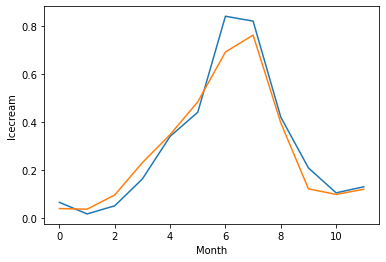

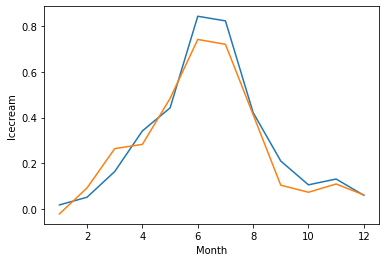

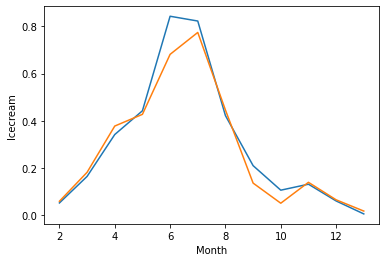

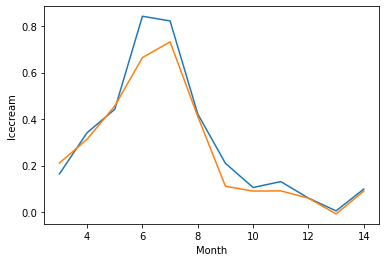

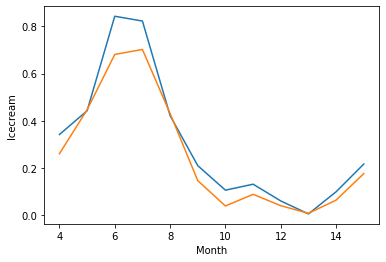

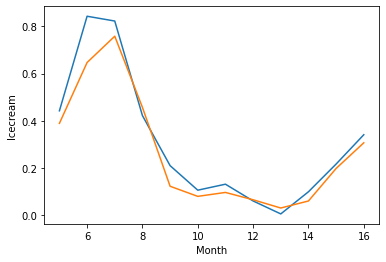

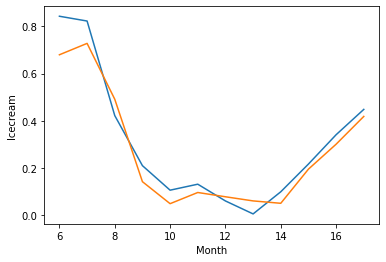

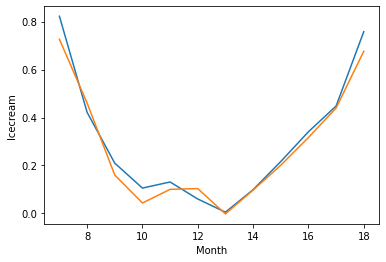

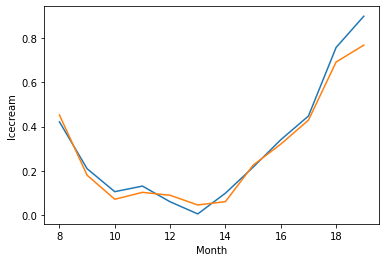

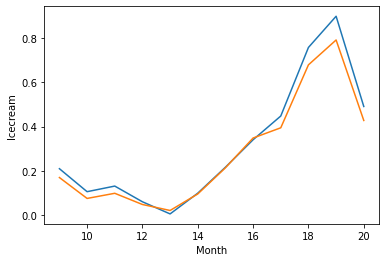

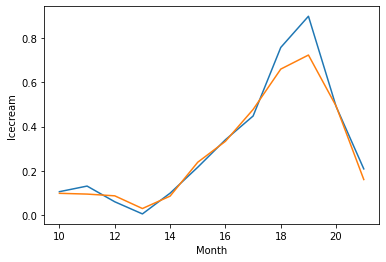

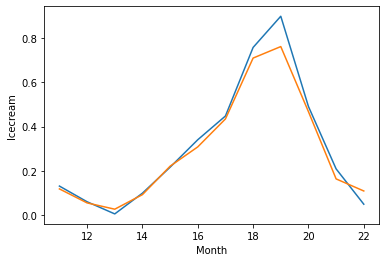

In [93]:
#plot 12 graphs corresponding to 12 inputs
for i in range(n_test):
    # i never reaches n_test, so that the max i = 11 => y[11-12] = y[-1]
    # x axis is extended along with y
    plt.plot(range(i, i + n_out), y[i-n_test]) 
    plt.plot(range(i,i+n_out), future_result[i])
    plt.xlabel('Month')
    plt.ylabel('Icecream')
    plt.show()

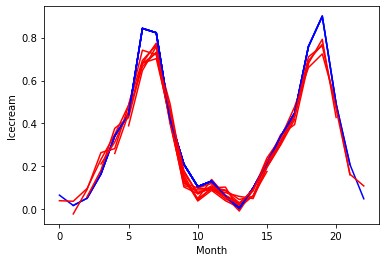

In [94]:
for i in range(n_test):
    plt.plot(range(i,i+n_out), y[i-n_test], c='b')
    plt.plot(range(i,i+n_out), future_result[i], c='r')
plt.xlabel('Month')
plt.ylabel('Icecream')
plt.show()

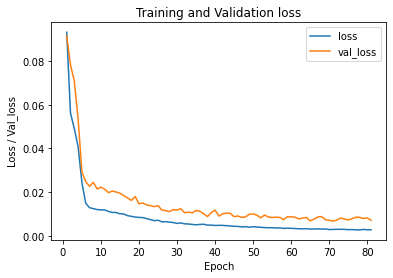

In [95]:
loss = fit_log.history["loss"]
val_loss = fit_log.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()